Copyright 2021 by Fatemeh Hadadi, University of Tehran.
All rights reserved.
This file is part of the Polyps Detection in Colonoscopy Images Project.
The dataset is downloadable at https://datasets.simula.no/kvasir/

# Import data and libraries

In [ ]:
import cv2
import os
import numpy as np
import argparse
from matplotlib import pyplot as plt
from PIL import Image, ImageFilter
from skimage.io import imread_collection
from scipy import ndimage, misc
import glob
import pandas as pd
import random
from tensorflow.keras.applications.resnet50  import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50  import preprocess_input
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow.keras as keras
from keras.optimizers import Adam
import math
from shutil import copyfile
from keras.models import load_model
from tqdm.notebook import tqdm
from sklearn.decomposition import PCA
from scipy.spatial import distance
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [ ]:
# load the location of dataset
org_polyp = os.path.realpath('kvasir-dataset/kvasir-dataset/polyps/')
org_normal = os.path.realpath('kvasir-dataset/kvasir-dataset/normal-cecum/')

# Split train and test

In [ ]:
# new folder address of train and test sets
trn_polyp = os.path.realpath('dataset/train/polyps/')
trn_normal = os.path.realpath('dataset/train/normal-cecum/')
val_polyp = os.path.realpath('dataset/test/polyps/')
val_normal = os.path.realpath('dataset/test/normal-cecum/')
# split train and test of images into two folders
dataset_size = 1000
split_rate = 0.7
rnd_polyp = [trn_polyp]* int(dataset_size*split_rate/2) +[val_polyp]* int(dataset_size/2-dataset_size*split_rate/2)
rnd_normal = [trn_normal]*int(dataset_size*split_rate/2)+[val_normal]*int(dataset_size/2-dataset_size*split_rate/2)

In [ ]:
# copy the images with polyp to train and test folders
try:
  os.makedirs(os.path.join(trn_polyp))
  os.makedirs(os.path.join(val_polyp))
except Exception:
  pass
files = os.listdir(os.path.join(org_polyp))
# shuffle to split the polyp images randomly
random.shuffle(rnd_polyp)
for filename, trg in zip(os.listdir(os.path.join(org_polyp)),rnd_polyp):
  scr = os.path.join(org_polyp,filename)
  dst = os.path.join(trg,filename)
  copyfile(scr,dst)
  # copy the normal images to train and test folders
try:
  os.makedirs(os.path.join(trn_normal))
  os.makedirs(os.path.join(val_normal))
except Exception:
  pass
files = os.listdir(os.path.join(org_normal))
# shuffle to split the normal images randomly
random.shuffle(rnd_normal)
for filename, trg in zip(os.listdir(os.path.join(org_normal)),rnd_normal):
  scr = os.path.join(org_normal,filename)
  dst = os.path.join(trg,filename)
  copyfile(scr,dst)
# the result dataset with splited folders of train and test
DATA_DIR = 'dataset'
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
VALID_DIR = os.path.join(DATA_DIR, 'test')

# Image preprocessing


In [ ]:
SIZE = (224, 224)
BATCH_SIZE = 16
num_train_samples = sum([len(files) for r, d, files in os.walk(TRAIN_DIR)])
num_valid_samples = sum([len(files) for r, d, files in os.walk(VALID_DIR)])
num_train_steps = math.floor(num_train_samples/BATCH_SIZE)
num_valid_steps = math.floor(num_valid_samples/BATCH_SIZE)
gen = keras.preprocessing.image.ImageDataGenerator()
val_gen = keras.preprocessing.image.ImageDataGenerator()
batches = gen.flow_from_directory(TRAIN_DIR, target_size=SIZE,
                                  class_mode='categorical', shuffle=True, batch_size=BATCH_SIZE)
val_batches = val_gen.flow_from_directory(VALID_DIR, target_size=SIZE,
                                          class_mode='categorical', shuffle=True, batch_size=BATCH_SIZE)

Found 700 images belonging to 2 classes.
Found 300 images belonging to 2 classes.


# build model

In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False)
base_model.trainable = False
inputs = keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=True)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.3)(x)
outputs = keras.layers.Dense(2, activation="softmax")(x)
model = keras.Model(inputs, outputs)
model.summary()

94773248/94765736 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, None, None, 2048)  23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 4098      
Total params: 23,591,810
Trainable params: 4,098
Non-trainable params: 23,587,712
_________________________________________________________________


# Model Training

In [ ]:
# the first time model is trained by freezed resnet50 model
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(patience=5)
checkpointer = ModelCheckpoint('resnet50_best.h5', verbose=1, save_best_only=True)
model.fit(batches, steps_per_epoch=num_train_steps, epochs=20, callbacks=[early_stopping, checkpointer], validation_data=val_batches, validation_steps=num_valid_steps)
model.save('resnet50_final.h5')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/20
43/43 [==============================] - 43s 274ms/step - loss: 1.1037 - accuracy: 0.5380 - val_loss: 0.7879 - val_accuracy: 0.5208

Epoch 00001: val_loss improved from inf to 0.78792, saving model to resnet50_best.h5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/20
43/43 [==============================] - 11s 249ms/step - loss: 0.7682 - accuracy: 0.6096 - val_loss: 0.5929 - val_accuracy: 0.6771

Epoch 00002: val_loss improved from 0.78792 to 0.59293, saving model to resnet50_best.h5
Epoch 3/20
43/43 [==============================] - 11s 249ms/step - loss: 0.6094 - accuracy: 0.6637 - val_loss: 0.4893 - val_accuracy: 0.7708

Epoch 00003: val_loss improved from 0.59293 to 0.48933, saving model to resnet50_best.h5
Epoch 4/20
43/43 [==============================] - 11s 261ms/step - loss: 0.5006 - accuracy: 0.7471 - val_loss: 0.4247 - val_accuracy: 0.8264

Epoch 00004: val_loss improved from 0.48933 to 0.42475, saving model to resnet50_best.h5
Epoch 5/20
43/43 [==============================] - 11s 253ms/step - loss: 0.4682 - accuracy: 0.7778 - val_loss: 0.3746 - val_accuracy: 0.8333

Epoch 00005: val_loss improved from 0.42475 to 0.37465, saving model to resnet50_best.h5
Epoch 6/20
43/43 [==============================] - 11s 260ms/step -

In [ ]:
# the second time all layers of model are trained
base_model.trainable = True

In [ ]:
model.compile(optimizer=Adam(lr=0.000001), loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(patience=5)
checkpointer = ModelCheckpoint('resnet50_fine_best.h5', verbose=1, save_best_only=True)
model.fit(batches, steps_per_epoch=num_train_steps, epochs=20, callbacks=[early_stopping, checkpointer], validation_data=val_batches, validation_steps=num_valid_steps)
model.save('resnet50_fine_final.h5')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/20
43/43 [==============================] - 22s 361ms/step - loss: 1.1569 - accuracy: 0.5614 - val_loss: 1.0243 - val_accuracy: 0.5868

Epoch 00001: val_loss improved from inf to 1.02432, saving model to resnet50_fine_best.h5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/20
43/43 [==============================] - 14s 324ms/step - loss: 0.8776 - accuracy: 0.6243 - val_loss: 0.8263 - val_accuracy: 0.6319

Epoch 00002: val_loss improved from 1.02432 to 0.82635, saving model to resnet50_fine_best.h5
Epoch 3/20
43/43 [==============================] - 14s 332ms/step - loss: 0.6763 - accuracy: 0.6977 - val_loss: 0.6888 - val_accuracy: 0.6806

Epoch 00003: val_loss improved from 0.82635 to 0.68881, saving model to resnet50_fine_best.h5
Epoch 4/20
43/43 [==============================] - 14s 331ms/step - loss: 0.5329 - accuracy: 0.7398 - val_loss: 0.5372 - val_accuracy: 0.7153

Epoch 00004: val_loss improved from 0.68881 to 0.53725, saving model to resnet50_fine_best.h5
Epoch 5/20
43/43 [==============================] - 14s 334ms/step - loss: 0.4480 - accuracy: 0.7865 - val_loss: 0.4567 - val_accuracy: 0.7674

Epoch 00005: val_loss improved from 0.53725 to 0.45667, saving model to resnet50_fine_best.h5
Epoch 6/20
43/43 [==============================

# Feature Extraction

In [ ]:
def preprocess(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    # Convert image to numpy array of 3-dimensions
    x = image.img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    # preprocess the images using preprocess_input() from ResNet50 module
    x = preprocess_input(x)
    return x
# Function to extract features of a given image into a vector of size (2048, )
def feature_extractor(image):
    image = preprocess(image) # preprocess the image
    fea_vec = fea_ext_model.predict(image) # Get the feature vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return fea_vec


In [ ]:
last = model.layers[-3].output
fea_ext_model =keras.Model(model.input, last)
polyps = [file for file in glob.glob('dataset/train/polyps/*.jpg')]
normals = [file for file in glob.glob('dataset/train/normal-cecum/*.jpg')]
data = []
for img in tqdm(polyps):
  data.append((feature_extractor(img), 1))
for img in tqdm(normals):
  data.append((feature_extractor(img), 0))

random.shuffle(data)
X = []
y = []
for d in data:
  X.append(d[0])
  y.append(d[1])
X = np.array(X)
y = np.array(y)

In [ ]:
polyps_test = [file for file in glob.glob('dataset/test/polyps/*.jpg')]
normals_test = [file for file in glob.glob('dataset/test/normal-cecum/*.jpg')]
data_test = []
for img in tqdm(polyps_test):
  data_test.append((feature_extractor(img), 1))
for img in tqdm(normals_test):
  data_test.append((feature_extractor(img), 0))

random.shuffle(data_test)
X_test = []
y_test = []
for d in data_test:
  X_test.append(d[0])
  y_test.append(d[1])
X_test = np.array(X_test)
y_test = np.array(y_test)


# PCA

In [ ]:
X_total = np.concatenate([X, X_test])
pca1 = PCA(n_components=1000)
pca1.fit(X_total)
n_comp = pca1.explained_variance_[pca1.explained_variance_ > 0.1].shape[0]
print(n_comp)
pca = PCA(n_components=n_comp)
x_total = pca.fit_transform(X_total)
x_pca = x_total[:700]
X_test  = x_total[700:]

34


# Data Augmentation

In [ ]:
n = len(x_pca)
for i in range(n):
  # find knn
  min = 10000000
  idx = -1
  min2 = 10000000
  idx2 = -1
  for j in range(n):
    if (i!=j) and (y[i]==y[j]):
      dst = distance.euclidean(x_pca[i],x_pca[j])
      if dst < min:
        min2 = min
        idx2 = idx
        min = dst
        idx = j
      elif dst < min2:
        min2 = dst
        idx2 = j
  # add interpolation
  new = 0.5*(x_pca[idx]-x_pca[i])+x_pca[i]
  x_pca = np.append(x_pca, [new], axis = 0)
  y = np.append(y,[y[i]], axis = 0)
  # add outerpolation
  new = -0.5*(x_pca[idx]-x_pca[i])+x_pca[i]
  x_pca = np.append(x_pca, [new], axis = 0)
  y = np.append(y,[y[i]], axis = 0)


# Classification

In [ ]:
X_train = x_pca
y_train = y
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
dtree = DecisionTreeClassifier(criterion='gini', random_state=40)
adbclassifier = AdaBoostClassifier(base_estimator=dtree, 
                                   n_estimators=400, 
                                   learning_rate=0.000005,
                                   algorithm = 'SAMME',
                                   random_state=40)
adbclassifier.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=None,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                         

# Result

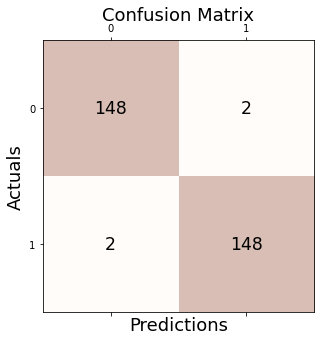

In [ ]:
y_pred = adbclassifier.predict(X_test)
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center',
                ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [ ]:
tn = conf_matrix[0, 0]
tp = conf_matrix[1, 1]
fn = conf_matrix[1, 0]
fp = conf_matrix[0, 1]
print('Specificity: %.3f' % float(tn/(tn+fp)))
print('Sensitivity: %.3f' % float(tp/(tp+fn)))
print('FPR: %.3f' % float(fp/(fp+tn)))
print('Recall: %.3f' % recall_score(y_test, y_pred))
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))
print('F1 Score: %.3f' % f1_score(y_test, y_pred))
error_rate = 1- accuracy_score(y_test, y_pred)
print('Error: %.3f' % error_rate)

Specificity: 0.987
Sensitivity: 0.987
FPR: 0.013
Recall: 0.987
Accuracy: 0.987
F1 Score: 0.987
Error: 0.013


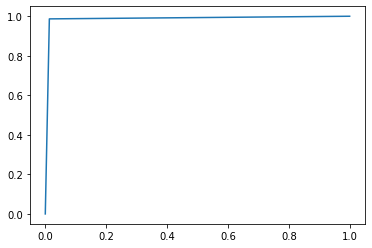

In [ ]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred)
auc_keras = auc(fpr_keras, tpr_keras)
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.show()